In [1]:
import emcee
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
exec(open("ltco_utils.py", "r").read())

In [2]:
%matplotlib widget

In [3]:
def log_likelihood(theta, x, y, yerr):

    # -- extract parameters
    coeffs = theta[:-2]
    offset, log_f = theta[-2:]
    
    # -- define the model
    model = np.dot(x, coeffs) + offset
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)

    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [4]:
def log_prior(theta):

    # -- extract parameters
    coeffs = theta[:-2]
    offset, log_f = theta[-2:]

    # -- find minimum and maximum coefficient values
    minco, maxco = coeffs.min(), coeffs.max()
    
    # -- set the conditions
    if minco < 0:
        return -np.inf
    else:
        return 0.0

In [5]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [6]:
def least_squares_loss(params, templates, spec):
    """
    Simple least squares loss function
    """
    
    # -- extract the coefficients
    coeffs = params[:-1]
    offset = params[-1]
    
    # -- create the model
    model = np.dot(templates, coeffs) + offset
    
    # -- return least squares
    return ((spec - model)**2).sum()

In [7]:
# -- read the aggregate spectra
fname13 = "../output/aggregate_no_constructions_2013.npy"
fname18 = "../output/aggregate_no_constructions_2018.npy"

# -- read the spectra
agg13 = np.load(fname13)
agg18 = np.load(fname18)

# -- get wavelengths
waves13 = get_wavelengths(2013)
waves18 = get_wavelengths(2018)

# -- load the templates
tname = "../output/final_lab_spectra.npy"
twname = "../output/final_lab_spectra_wavelengths.npy"
tnname = "../output/final_lab_spectra_names.npy"
templs = np.load(tname)
twaves = np.load(twname)
tnames = np.load(tnname, allow_pickle=True)

# -- get quantum efficiency
qe = pd.read_csv("../data/hsi1-qe.csv", delimiter="\t")

# -- interpolate aggregate spectra onto template wavelengths
agg13i = np.interp(twaves, waves13, agg13)
agg18i = np.interp(twaves, waves18, agg18)
qe = np.interp(twaves, qe["wavelength_nm"], qe["quantum_efficiency"]) * 0.01

# -- apply quantum efficiency
templs *= qe[:, None]

reading and parsing full frame 20ms faster_VNIR.hdr...
reading full frame 20ms faster_VNIR.raw...
reading and parsing night_00000.hdr...
reading night_00000.raw...


In [8]:
# -- estimate the measurement error
yerr13 = (agg13i[1:] - agg13i[:-1])[-50:].std() / np.sqrt(2.0)

In [9]:
# -- normal equation solution
P = np.concatenate((templs, np.ones_like(templs[:, None, 0])), axis=1)
PtP = np.dot(P.T, P)
Ptb = np.dot(P.T, agg13i)
avec = np.dot(np.linalg.inv(PtP), Ptb)

In [12]:
# -- find the maximum likelihood solution for 2013
res13 = minimize(least_squares_loss, avec.clip(min=0), 
                 args=(templs, agg13i), 
                 bounds=[(0, np.inf)] * 45 + [(-np.inf, np.inf)])

# -- find the maximum likelihood solution for 2018
res18 = minimize(least_squares_loss, avec.clip(min=0), 
                 args=(templs, agg18i), 
                 bounds=[(0, np.inf)] * 45 + [(-np.inf, np.inf)])

In [13]:
# -- create 2013 and 2018 models
model13 = np.dot(templs, res13.x[:-1]) + res13.x[-1]
model18 = np.dot(templs, res18.x[:-1]) + res18.x[-1]

In [14]:
# -- get the indices of the LED and HPS spectra
lind = [i for i, n in enumerate(tnames) if "LED:" in n]
hind = [i for i, n in enumerate(tnames) if "HPS:" in n]

# -- make the LED and HPS components for 2013 and 2018
led13 = np.dot(templs[:, lind], res13.x[lind])
hps13 = np.dot(templs[:, hind], res13.x[hind])
led18 = np.dot(templs[:, lind], res18.x[lind])
hps18 = np.dot(templs[:, hind], res18.x[hind])

In [15]:
# -- sum all spectra and offsets
HPS13 = np.multiply(templs[:, hind], res13.x[hind]).sum(axis=0)
LED13 = np.multiply(templs[:, lind], res13.x[lind]).sum(axis=0)

# -- sum all spectra and offsets
HPS18 = np.multiply(templs[:, hind], res18.x[hind]).sum(axis=0)
LED18 = np.multiply(templs[:, lind], res18.x[lind]).sum(axis=0)

In [12]:
# -- calculate signal value
signal_val13 = HPS13.sum()/LED13.sum()
signal_val13

1.1631410657764751

In [16]:
signal_val18 = HPS18.sum()/LED18.sum()
signal_val18

0.29792636557369195

In [17]:
HPS13

array([ 6.48578219, 22.39782045,  0.        ])

Text(0.5, 0, 'wavelength [microns]')

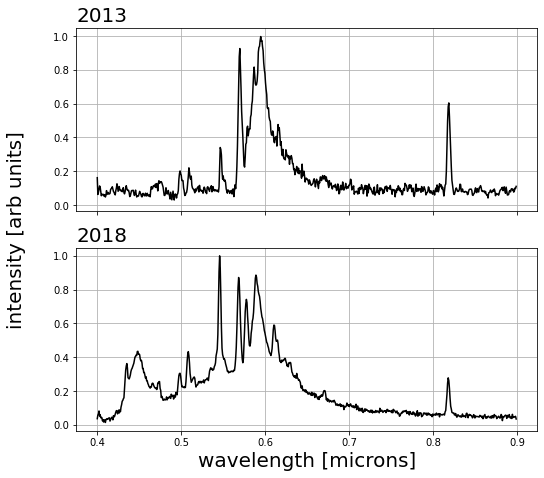

In [38]:
# -- plot the 2013 solution
plt.close("all")
# plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(8, 8))
fig.subplots_adjust(0.1, 0.15, 0.9, 0.85, wspace=0.05)
ax[0].plot(twaves/1000, agg13i, "k", label="aggregate spectrum")
ax[0].grid(":", axis="x", zorder=9)
ax[0].grid(":", axis="y", zorder=9)

ax[0].set_title("2013", loc="left", fontsize = 20)
# ax[0].set_ylabel("intensity [arb units]")
ax[0].set_xticklabels([])

ax[1].plot(twaves/1000, agg18i, "k", label="aggregate spectrum")
ax[1].grid(":", axis="y", zorder=9)

ax[1].grid(":", axis="x", zorder=9)
ax[1].set_title("2018", loc="left",  fontsize = 20)
fig.text(-0.02, 0.5, 'intensity [arb units]', va='center', rotation='vertical', fontsize = 20)
ax[1].set_xlabel("wavelength [microns]", fontsize = 20)

model13

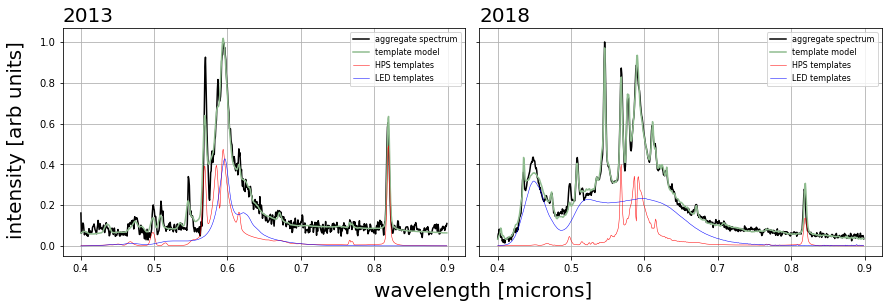

In [56]:
# -- plot the 2013 solution
plt.close("all")
# plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
fig.subplots_adjust(0.1, 0.15, 0.9, 0.85, wspace=0.05)
ax[0].plot(twaves/1000, agg13i, "k", label="aggregate spectrum")
ax[0].plot(twaves/1000, model13, "darkseagreen", label="template model")
ax[0].plot(twaves/1000, hps13, "r", label="HPS templates", lw=0.5)
ax[0].plot(twaves/1000, led13, "b", label="LED templates", lw=0.5)
ax[0].grid(":", axis="x", zorder=9)
ax[0].grid(":", axis="y", zorder=9)

ax[0].legend(fontsize=8, loc="upper right")
ax[0].set_title("2013", loc="left",  fontsize = 20)

ax[1].plot(twaves/1000, agg18i, "k", label="aggregate spectrum")
ax[1].plot(twaves/1000, model18, "darkseagreen", label="template model")
ax[1].plot(twaves/1000, hps18, "r", label="HPS templates", lw=0.5)
ax[1].plot(twaves/1000, led18, "b", label="LED templates", lw=0.5)
ax[1].grid(":", axis="x", zorder=9)
ax[1].grid(":", axis="y", zorder=9)

ax[1].legend(fontsize=8)
ax[1].set_title("2018", loc="left",  fontsize = 20 )
fig.text(-0.025, 0.5, 'intensity [arb units]', va='center', rotation='vertical', fontsize = 20)
fig.text(0.4, -0.025, 'wavelength [microns]', va='center',  fontsize = 20)
fig.tight_layout()

In [14]:
# -- initialize parameters
np.random.seed(302)
# params13 = np.array([0.5] * templs.shape[1] + [0.5] + [0.5]) + 1.0 * np.random.randn(4, templs.shape[1] + 2)
# params13 = 5 * np.random.rand(96, templs.shape[1] + 2)
params13 = np.abs(np.append(res.x, 0.01) + 1e-2 * np.random.randn(96, res.x.size + 1))

# -- define the walkers
nwalkers, ndim = params13.shape

# -- initialize the sampler and run
sampler13 = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(templs, agg13i, yerr13))
sampler13.run_mcmc(params13, 50000, progress=True);

NameError: name 'res' is not defined

In [47]:
# -- get chains
samples = sampler13.get_chain()

In [1]:
def make_model(sampler, templates, params=None):
    
    # -- get coefficients
    params = np.median(sampler.get_chain(discard=5000, thin=15, flat=True), axis=0)
    coeffs = params[:-2]
    offset = params[-2]
    
    # -- make the model
    return np.dot(templates, coeffs) + offset

In [50]:
model = make_model(sampler13, templs)

In [113]:
# flat_samples = sampler13.get_chain(discard=5000, thin=100, flat=True)
# fig = corner.corner(flat_samples, 
#                     labels=[i[:10] for i in tnames] + ["offset", "logf"], 
#                     truths=list(res.x) + [0.0]);